# Training an Object Detection Model with Determined

We're going to use Determined to build an object detection model, trained on the VOC2012 Dataset
<img src="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/examples/images/sheep_06.jpg" align='center' width=400 />

The data was landed into a Delta Table with Spark

<img src="spark/resources/ETL.png" width=300 />



In [2]:
!pip install pyarrow

     |████████████████████████████████| 63.8 MB 37.1 MB/s eta 0:00:01


## Without Determined

In [2]:
from models import ObjectDetectionModel
model = ObjectDetectionModel({'lr': 0.0025, 'm': 0.9})


In [3]:
NUM_EPOCHS = 10
try:
    for epoch in range(NUM_EPOCHS):
        print(f"Training epoch {epoch + 1} of {NUM_EPOCHS}")
        model.train_one_epoch()
        model.eval()
except KeyboardInterrupt:
    pass

Training epoch 1 of 10



mAP: 0.029319417357717432
Training epoch 2 of 10


## Hyperparameter Search with Determined

In [6]:
!cat search.yaml

batches_per_step: 20
data:
  bucket: david-voc-delta
  train:
    table: train
    version: 0
  val:
    table: val
    version: 0
description: training
entrypoint: model_def:ObjectDetectionModel
hyperparameters:
  global_batch_size: 4
  learning_rate:
    base: 10
    maxval: -2
    minval: -4
    type: log
  momentum:
    maxval: 0.95
    minval: 0.7
    type: double
  weight_decay: 0.0005
  load_from_experiment: -1
min_validation_period: 10
resources:
  slots_per_trial: 1
searcher:
  max_steps: 1000
  max_trials: 32
  metric: 'mAP'
  name: adaptive_simple
  smaller_is_better: false


In [ ]:
!det e create search.yaml .

To train our model, we'll do a hyperparameter search with Determined.

# How can we improve?

With a little investigating, we can see that there is a class imbalance, we don't have enough examples of 'dogs'

<img src="dataset_v1.png" width=800 />

Once we manage to collect and label more images, then add them to a new version of the Delta table:

<img src="dataset_v2.png" width=800 />

### Quickly Training with New Data
With a new dataset, lets make a new experiment in Determined.  This time we'll fine tune the best model produced by our last experiment, using 16-GPU distributed training to accelerate the process.

In [7]:
!cat distributed.yaml

batches_per_step: 20
data:
  bucket: david-voc-delta
  train:
    table: train
    version: 1
  val:
    table: val
    version: 0
description: distributed
entrypoint: model_def:ObjectDetectionModel
hyperparameters:
  global_batch_size: 64
  learning_rate: 0.001
  momentum: 0.9
  weight_decay: 0.0001
  load_from_experiment: 1
min_validation_period: 20
resources:
  slots_per_trial: 16
searcher:
  max_steps: 60
  metric: 'mAP'
  name: single
  smaller_is_better: false


In [ ]:
!det e create distributed.yaml .

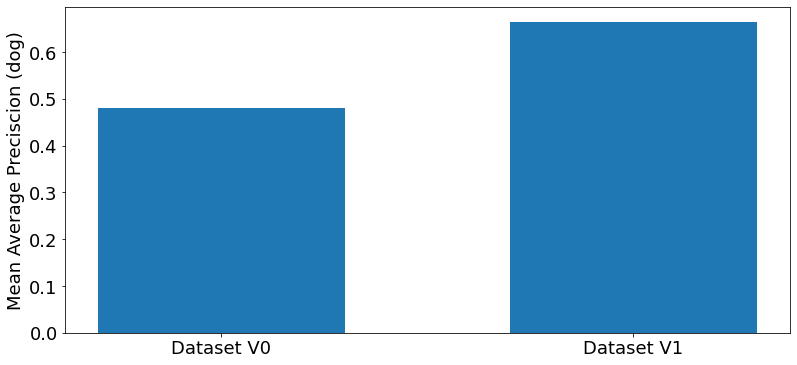

In [21]:
from utils import show_dog_comparison

show_dog_comparison()

## Inference 
Inference (and how to launch it) is highly dependant on how you use Spark.  To see example inference code, check out [this reference PySpark notebook](spark/batch_inference.ipynb)